# Import Packages

In [1]:
from numpy.random import seed
seed(333)
import tensorflow as tf
tf.random.set_seed(333)

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [3]:
import pandas as pd
import numpy as np
from pyecg import ECGRecord
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
import random
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from statistics import mean
from sklearn.metrics import r2_score
from numpy import arange

Set seed

In [4]:
np.random.seed(333)

# Read in Data

In [5]:
x_test_data = pd.read_csv('x_test_3.csv') 
y_test_data = pd.read_csv('y_test_3.csv') 
x_train_data = pd.read_csv('x_train_3.csv') 
y_train_data = pd.read_csv('y_train_3.csv') 

# Create LSTM Model

Separate X and y data

In [6]:
X_train = x_train_data[['i','ii','v2']]
X_test = x_test_data[['i','ii','v2']]
y_train = [y_train_data["v1"],y_train_data["v3"],y_train_data["v4"],y_train_data["v5"],y_train_data["v6"]]
y_test = [y_test_data["v1"],y_test_data["v3"],y_test_data["v4"],y_test_data["v5"],y_test_data["v6"]]

Reshape data into arrays.

X arrays should be in the shape (number of patients, records per patient, number of predictors)

y arrays should be in the shape (number of patients, records per patient)

In [7]:
def X_array_reshape(X_data,record_number,var_number):
    X_arr = np.asarray(X_data)
    X_arr = np.reshape(X_arr, (int(len(X_data)/record_number), record_number, var_number))
    return(X_arr)
def y_array_reshape(y_data,record_number):
    y_arr = np.asarray(y_data)
    y_arr = np.reshape(y_arr,(int(len(y_data)/record_number),record_number))
    return(y_arr)

In [8]:
X_train_arr = X_array_reshape(X_train,30000,3)
X_test_arr = X_array_reshape(X_test,30000,3)
y_train_list = []
y_test_list = []
for i in range(0,5):
    y_train_list.append(y_array_reshape(np.asarray(y_train[i]),30000))


Define the LSTM model for each target lead.

The number after LSTM is number of nodes for the hidden layer.

input_shape is the data per patient (batch), it should be (none, 30000, 3). none means the number of patients is flexible and each patient has 30000 timesteps with 3 variables.

Must have return_sequences = True so model creates predictions for every record or else the model will only output one value per patient.

This model uses sigmoid activation function in the hidden layer (default parameter).

When fitting model, batch_size can be changed to tune the model a little. You can decrease the number of epochs to have faster run time but this may lead to lower performance.

verbose is not a model parameter, it affects how much output text you get for each epoch.

In [9]:
# uncomment the lines about the training dataset to calculate performance on training data
# note: this increases run time from ~20 hours to ~100 hours
def LSTM_model(X_train,X_test,y_train,y_test,record_number,var_number):
    a = y_train
    #train_correlation = []
    #train_rmse = []
    test_correlation = []
    test_rmse = []
    test_predictions = []
    for i in range(0,5):
        model = Sequential()
        model.add(LSTM(15,input_shape=(record_number, var_number), return_sequences = True))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(X_train, y_train_list[i], epochs=150, batch_size=5, verbose=0)
        #prediction = model.predict(X_train)
        #prediction_list = sum(sum(prediction.tolist(), []),[])
        #train_correlation.append(math.sqrt(abs(r2_score(y_train[i], prediction_list))))
        #train_rmse.append(math.sqrt(mean_squared_error(y_train[i], prediction_list)))
        prediction = model.predict(X_test)
        prediction_list = sum(sum(prediction.tolist(), []),[])
        test_correlation.append(math.sqrt(r2_score(y_test[i], prediction_list)))
        test_rmse.append(math.sqrt(mean_squared_error(y_test[i], prediction_list)))
        test_predictions.append(prediction_list)
    return(
        #train_correlation,train_rmse,
        test_correlation,test_rmse,test_predictions
        )

In [ ]:
model_results = LSTM_model(X_train_arr,X_test_arr,y_train,y_test,30000,3)

1/1 [==============================] - 2s 2s/step


In [ ]:
#model_results

# Check Performance

In [ ]:
# uncomment if model contains training dataset performance
#def performance_train(model):
#    target_leads = ["V1","V3","V4","V5","V6"]
#    for i in range(0,5):
#        print(target_leads[i],"\n","Correlation:","{:.3f}".format(model_results[0][i]),"\n","RMSE:","{:.3f}".format(model_results[1][i]),"\n")


# If the model included training performance, change model_results[0] and model_results[1] to model_results[2] and model_results[3]
def performance_test(model):
    target_leads = ["V1","V3","V4","V5","V6"]
    for i in range(0,5):
        print(target_leads[i],"\n","Correlation:","{:.3f}".format(model_results[0][i]),"\n","RMSE:","{:.3f}".format(model_results[1][i]),"\n")

In [ ]:
#performance_train(model_results)

V1 
 Correlation: 0.946 
 RMSE: 0.067 

V3 
 Correlation: 0.944 
 RMSE: 0.096 

V4 
 Correlation: 0.876 
 RMSE: 0.114 

V5 
 Correlation: 0.853 
 RMSE: 0.088 

V6 
 Correlation: 0.877 
 RMSE: 0.065 



In [ ]:
performance_test(model_results)

V1 
 Correlation: 0.896 
 RMSE: 0.096 

V3 
 Correlation: 0.945 
 RMSE: 0.095 

V4 
 Correlation: 0.818 
 RMSE: 0.131 

V5 
 Correlation: 0.836 
 RMSE: 0.101 

V6 
 Correlation: 0.870 
 RMSE: 0.074 



### Plot Predictions for one Patient

In [ ]:
time2 = []
for i in arange(60, 90, 0.001):
    time2.append(i)

In [ ]:
# If model included training results, use model_results[4] instead of model_results[2]

Text(0.5, 1.0, '')

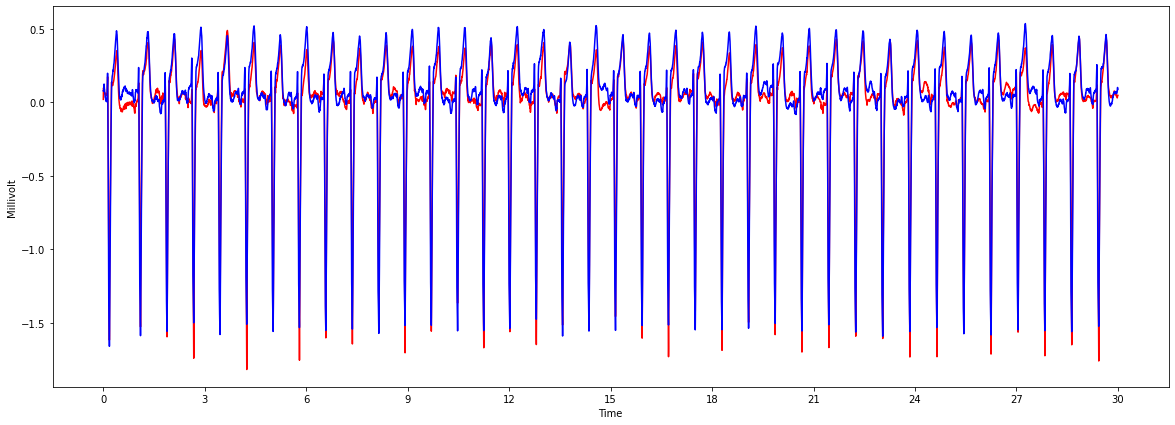

In [ ]:
#V1
plt.figure(figsize=(20,7))
plt.plot(time2, model_results[2][0][60000:90000],color = 'r')
plt.plot(time2, y_test[0][60000:90000],color='b')
x = [0,3,6,9,12,15,18,21,24,27,30]
xi = [60,63,66,69,72,75,78,81,84,87,90]
plt.xticks(xi, x)
plt.xlabel('Time')
plt.ylabel('Millivolt')
plt.title('')

Text(0.5, 1.0, '')

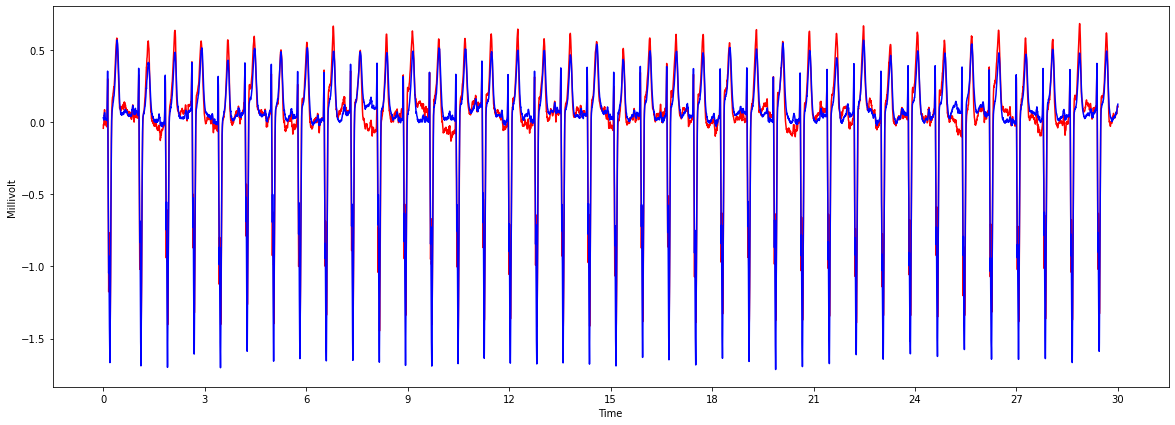

In [ ]:
#V3
plt.figure(figsize=(20,7))
plt.plot(time2, model_results[2][1][60000:90000],color = 'r')
plt.plot(time2, y_test[1][60000:90000],color='b')
x = [0,3,6,9,12,15,18,21,24,27,30]
xi = [60,63,66,69,72,75,78,81,84,87,90]
plt.xticks(xi, x)
plt.xlabel('Time')
plt.ylabel('Millivolt')
plt.title('')

Text(0.5, 1.0, '')

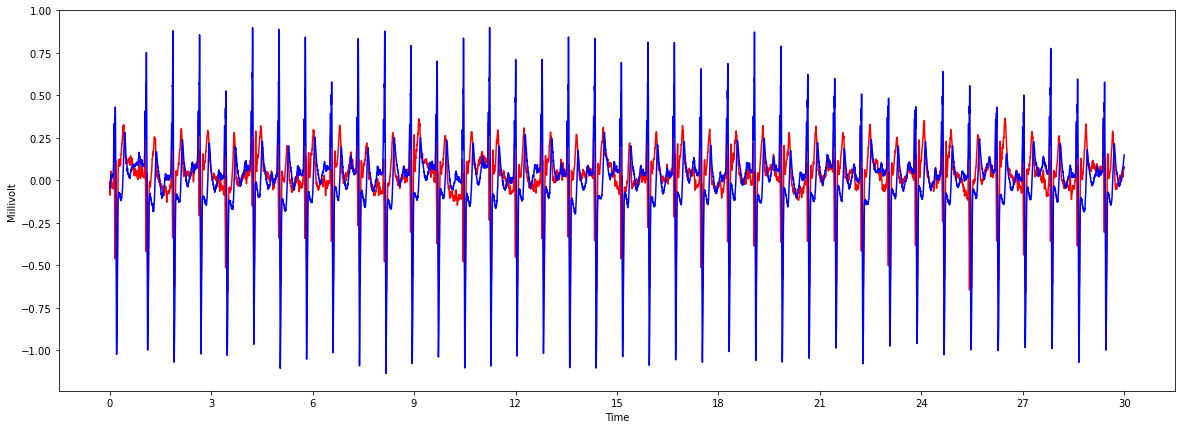

In [ ]:
#V4
plt.figure(figsize=(20,7))
plt.plot(time2, model_results[2][2][60000:90000],color = 'r')
plt.plot(time2, y_test[2][60000:90000],color='b')
x = [0,3,6,9,12,15,18,21,24,27,30]
xi = [60,63,66,69,72,75,78,81,84,87,90]
plt.xticks(xi, x)
plt.xlabel('Time')
plt.ylabel('Millivolt')
plt.title('')

Text(0.5, 1.0, '')

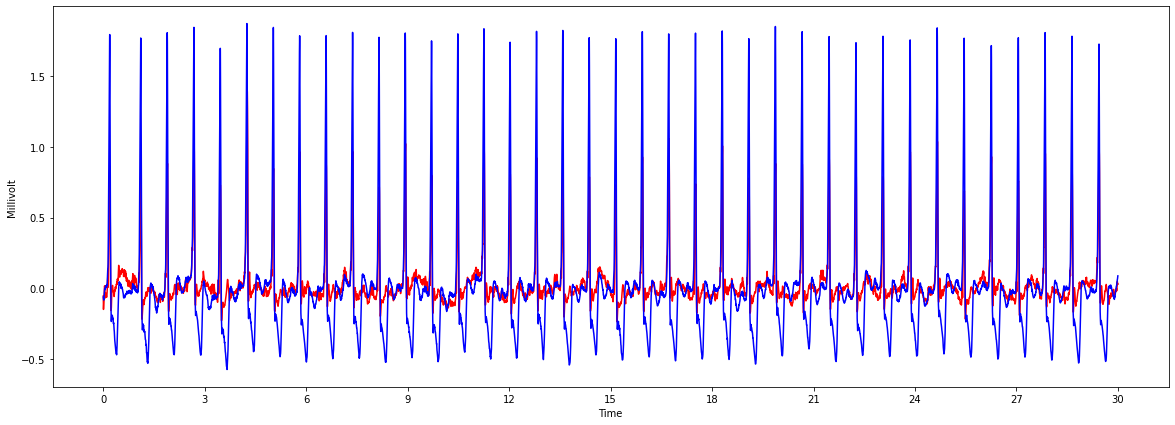

In [ ]:
#V5
plt.figure(figsize=(20,7))
plt.plot(time2, model_results[2][3][60000:90000],color = 'r')
plt.plot(time2, y_test[3][60000:90000],color='b')
x = [0,3,6,9,12,15,18,21,24,27,30]
xi = [60,63,66,69,72,75,78,81,84,87,90]
plt.xticks(xi, x)
plt.xlabel('Time')
plt.ylabel('Millivolt')
plt.title('')

Text(0.5, 1.0, '')

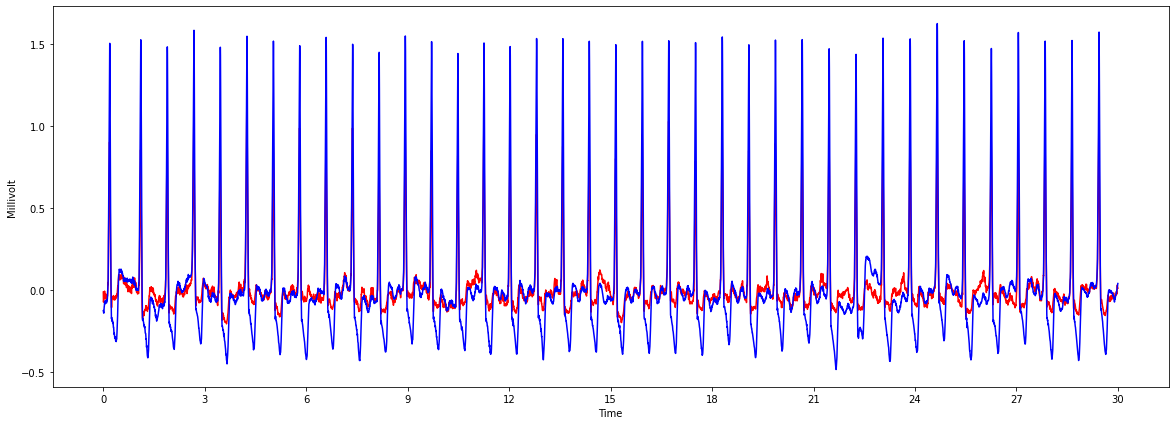

In [ ]:
#V6
plt.figure(figsize=(20,7))
plt.plot(time2, model_results[2][4][60000:90000],color = 'r')
plt.plot(time2, y_test[4][60000:90000],color='b')
x = [0,3,6,9,12,15,18,21,24,27,30]
xi = [60,63,66,69,72,75,78,81,84,87,90]
plt.xticks(xi, x)
plt.xlabel('Time')
plt.ylabel('Millivolt')
plt.title('')

### Plot Predictions for All Patients

In [ ]:
time = []
for i in arange(0, 300.000, 0.001):
    time.append(i)

Text(0.5, 1.0, '')

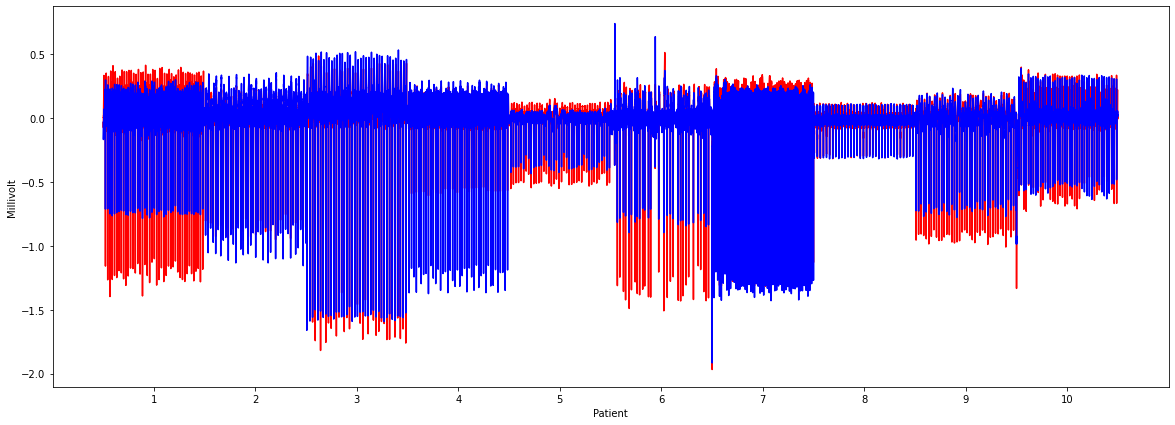

In [ ]:
#V1
plt.figure(figsize=(20,7))
plt.plot(time, model_results[2][0][:300000],color = 'r')
plt.plot(time, y_test[0][:300000],color='b')
x = [1,2,3,4,5,6,7,8,9,10]
xi = [15,45,75,105,135,165,195,225,255,285]
plt.xticks(xi, x)
plt.xlabel('Patient')
plt.ylabel('Millivolt')
plt.title('')

Text(0.5, 1.0, '')

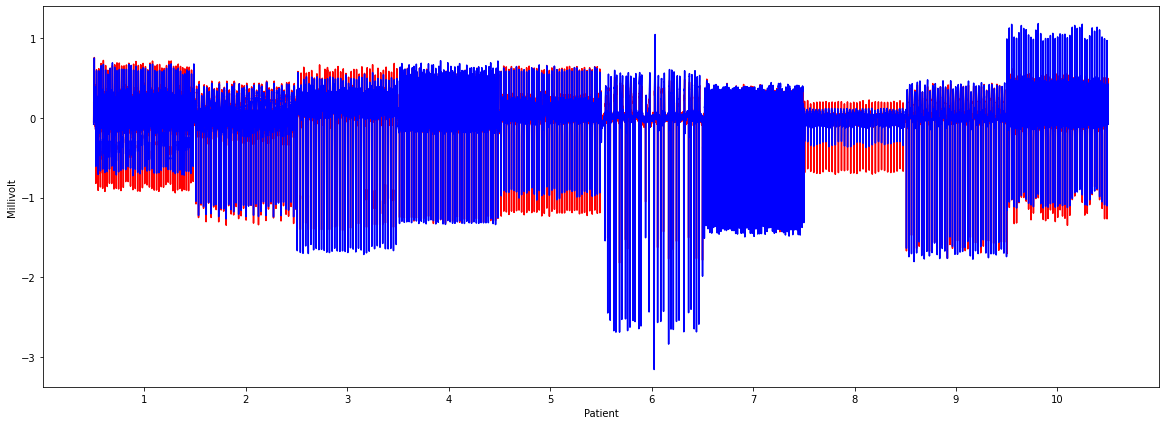

In [ ]:
#V3
plt.figure(figsize=(20,7))
plt.plot(time, model_results[2][1][:300000],color = 'r')
plt.plot(time, y_test[1][:300000],color='b')
x = [1,2,3,4,5,6,7,8,9,10]
xi = [15,45,75,105,135,165,195,225,255,285]
plt.xticks(xi, x)
plt.xlabel('Patient')
plt.ylabel('Millivolt')
plt.title('')

Text(0.5, 1.0, '')

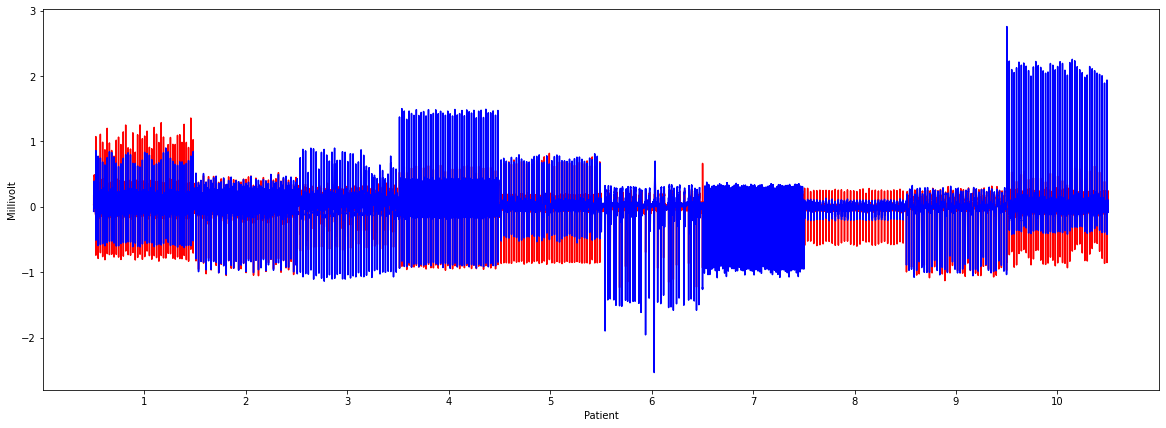

In [ ]:
#V4
plt.figure(figsize=(20,7))
plt.plot(time, model_results[2][2][:300000],color = 'r')
plt.plot(time, y_test[2][:300000],color='b')
x = [1,2,3,4,5,6,7,8,9,10]
xi = [15,45,75,105,135,165,195,225,255,285]
plt.xticks(xi, x)
plt.xlabel('Patient')
plt.ylabel('Millivolt')
plt.title('')

Text(0.5, 1.0, '')

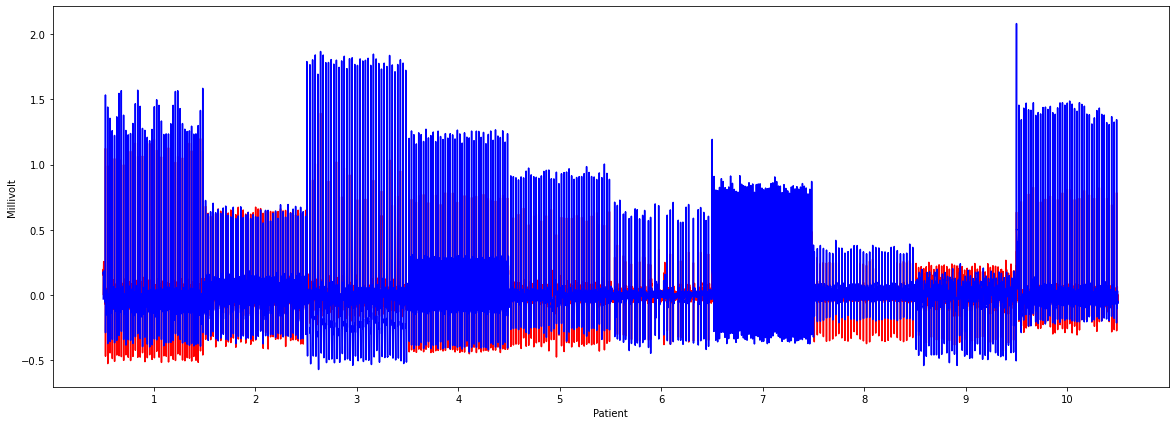

In [ ]:
#V5
plt.figure(figsize=(20,7))
plt.plot(time, model_results[2][3][:300000],color = 'r')
plt.plot(time, y_test[3][:300000],color='b')
x = [1,2,3,4,5,6,7,8,9,10]
xi = [15,45,75,105,135,165,195,225,255,285]
plt.xticks(xi, x)
plt.xlabel('Patient')
plt.ylabel('Millivolt')
plt.title('')

Text(0.5, 1.0, '')

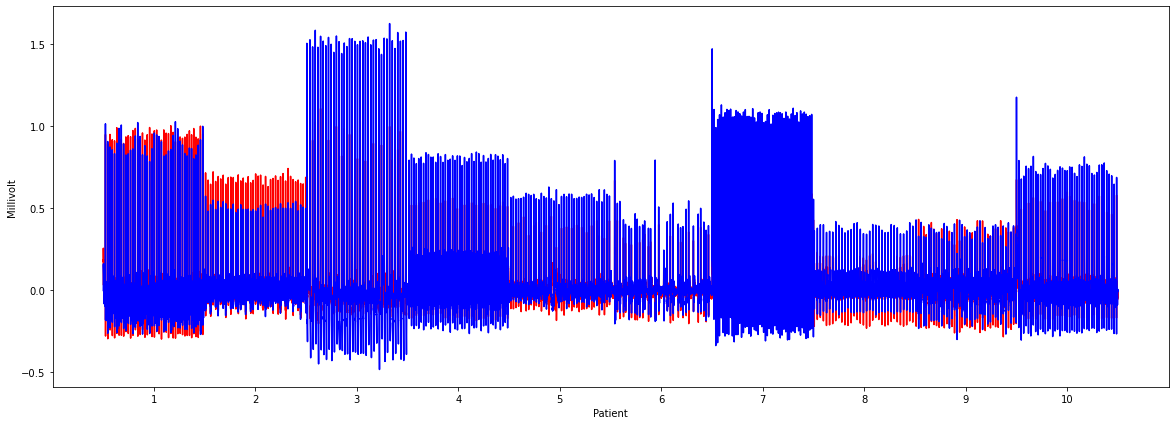

In [ ]:
#V6
plt.figure(figsize=(20,7))
plt.plot(time, model_results[2][4][:300000],color = 'r')
plt.plot(time, y_test[4][:300000],color='b')
x = [1,2,3,4,5,6,7,8,9,10]
xi = [15,45,75,105,135,165,195,225,255,285]
plt.xticks(xi, x)
plt.xlabel('Patient')
plt.ylabel('Millivolt')
plt.title('')